<a href="https://colab.research.google.com/github/JMFerret/colab/blob/main/2_stocks_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating correlated price stocks in a multi-asset basket
This notebook demonstrates how to simulate price paths in a basket containing >2 correlated assets. To achieve this, it applies [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition)  on the correlation matrix and generates an array of correlated random numbers. The notebook only serves a narrow demonstration purpose and as such lacks certain user flexiblities.

## Import libraries

In [55]:
#Import libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, exp
import pandas as pd

## Set coefficient matrix
Observe that the number of stocks and the coefficient matrix $\Sigma$ are treated as constants. When adjusting manually, carefully check that the matrix dimensions align with the number of stocks and that the correlation matrix is semi-definite positive (requirement for Cholesky decomposition).

For this example, volatilies and correlation coefficients for the [Big Tech companies](https://en.wikipedia.org/wiki/Big_Tech)  over 2020 were calculated.

In [56]:
# Manually input number of stocks
NUMBER_OF_STOCKS = 2

STOCK_TICKERS = ["AAPL", "AMZN"]

VOLATILITY_ARRAY =[0.50, 0.10]

COEF_MATRIX = np.array([
    [1.0000000000000000, 0.6971648047240692],
    [0.6971648047240692, 1.0000000000000000],
])

print(COEF_MATRIX)

[[1.        0.6971648]
 [0.6971648 1.       ]]


## Perform Cholesky decomposition
This cell performs the Cholesky decomposition on the coefficient matrix $\Sigma$, returning a matrix $R$ that satisfies $\Sigma=R R^*$ and $R^*$ being the conjugate transpose of $R$. Note that the other computations are only for validation purposes.

In [57]:
# Perform Cholesky decomposition on coefficient matrix
R = np.linalg.cholesky(COEF_MATRIX)

# Compute transpose conjugate (only for validation)
RT = R.T.conj()

# Reconstruct coefficient matrix from factorization (only for validation)
print(np.dot(R, RT))

[[1.        0.6971648]
 [0.6971648 1.       ]]


## Initialize simulation properties
For simplicitly, all stocks have the same initial price $S_{n,0}$ and the same volatility $v_n$.

In [58]:
T = 252                                                  # Number of simulated days
stock_price_array = np.full((NUMBER_OF_STOCKS,T), 100.0) # Stock price, first value is simulation input 
volatility_array = VOLATILITY_ARRAY                      # Volatility (annual, 0.01=1%)
r = 0.001                                                # Risk-free rate (annual, 0.01=1%)
dt = 1.0 / T                                             # Time increment (annualized)

## Run simulation
For each time step, the cell generates a number of standard normal numbers (randomly drawn) and multiplies this with the $R$ matrix obtained from the Cholesky decomposition, yielding an epsilon array with correlated values. Mathematically, this procedure is denoted by $[\epsilon_n]_{\forall n \in \mathcal{N}} =R[x_n]_{\forall n \in \mathcal{N}}$, with $\mathcal{N}$ being the set of assets. The epsilons $\epsilon_n$ are used as inputs for the boilerplate return formula as derived from the Black-Scholes model: $S_t=S_{t-1} * e^{\left(r_f - \frac{\sigma ^2}{2}\right)}  dt + \sigma  \sqrt{dt}  \epsilon_n$

In [59]:
for t in range(1, T):
    # Generate array of random standard normal draws
    random_array = np.random.standard_normal(NUMBER_OF_STOCKS)
    
    # Multiply R (from factorization) with random_array to obtain correlated epsilons
    epsilon_array = np.inner(random_array,R)

    # Sample price path per stock
    for n in range(NUMBER_OF_STOCKS):
        dt = 1 / T 
        S = stock_price_array[n,t-1]
        v = volatility_array[n]
        epsilon = epsilon_array[n]
        
        # Generate new stock price
        stock_price_array[n,t] = S * exp((r - 0.5 * v**2) * dt + v * sqrt(dt) * epsilon)

## Plot simulated paths
With the default settings, the price paths should be highly correlated.

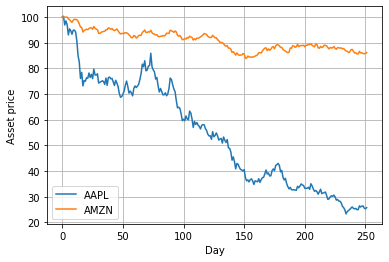

In [60]:
# Plot simulated price paths
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
array_day_plot = [t for t in range(T)]

for n in range(NUMBER_OF_STOCKS):
    ax.plot(array_day_plot, stock_price_array[n],\
                        label = '{}'.format(STOCK_TICKERS[n]))

plt.grid()
plt.xlabel('Day')
plt.ylabel('Asset price')
plt.legend(loc='best')

plt.show()

In [89]:
weights = {} 
for stock in STOCK_TICKERS:
  weights[stock] = 1 / NUMBER_OF_STOCKS

index = []
for t in range(T):
  index.append(0)
  for i, stock in enumerate(STOCK_TICKERS):
    index[t] += weights[stock] * stock_price_array[i][t]


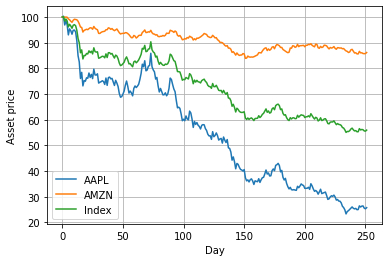

In [90]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
array_day_plot = [t for t in range(T)]

for n in range(NUMBER_OF_STOCKS):
    ax.plot(array_day_plot, stock_price_array[n],\
                        label = '{}'.format(STOCK_TICKERS[n]))
    
ax.plot(array_day_plot, index, label = 'Index')
plt.grid()
plt.xlabel('Day')
plt.ylabel('Asset price')
plt.legend(loc='best')

plt.show()

In [118]:
df = pd.DataFrame(stock_price_array)
df = df.transpose()
df = df.rename(columns={0: "AAPL", 1: "AMZN"})
df["Index"] = index
cols = ["AAPL", "AMZN", "Index"]
for col in cols:
  df[col + '_returns'] = df[col].pct_change(1)

# Check realised vol
# for col in cols:
#   print(df[col + '_returns'].dropna().std() * np.sqrt(T))

df['Portfolio_value'] = 0.0
for stock in STOCK_TICKERS:
  df[stock + '_weight'] = 0.0
  df[stock + '_value'] = 0.0
  df.at[0, stock + '_weight'] =  weights[stock]
  df.at[0, stock + '_value'] =  df[stock].iloc[0] * weights[stock]
  df.at[0, 'Portfolio_value'] +=  df[stock + '_value'].iloc[0]

  for t in range(1, T):
    df.at[t, stock + '_weight'] = weights[stock]
    df.at[t, stock + '_value'] = df[stock].iloc[t] * weights[stock]
    df.at[t, 'Portfolio_value'] += df[stock + '_value'].iloc[t]

df

,AAPL,AMZN,Index,AAPL_returns,AMZN_returns,Index_returns,Portfolio_value,AAPL_weight,AAPL_value,AMZN_weight,AMZN_value
0,100.000000,100.000000,100.000000,NaN,NaN,NaN,100.000000,0.5,50.000000,0.5,50.000000
1,100.297818,100.017861,100.157840,0.002978,0.000179,0.001578,100.157840,0.5,50.148909,0.5,50.008931
2,96.896096,99.909127,98.402611,-0.033916,-0.001087,-0.017525,98.402611,0.5,48.448048,0.5,49.954563
3,98.495055,99.991804,99.243429,0.016502,0.000828,0.008545,99.243429,0.5,49.247527,0.5,49.995902
4,96.985223,99.911332,98.448277,-0.015329,-0.000805,-0.008012,98.448277,0.5,48.492612,0.5,49.955666
...,...,...,...,...,...,...,...,...,...,...,...
247,26.335685,86.064700,56.200192,0.013465,0.000462,0.003479,56.200192,0.5,13.167843,0.5,43.032350
248,26.405544,85.776098,56.090821,0.002653,-0.003353,-0.001946,56.090821,0.5,13.202772,0.5,42.888049
249,25.544929,85.717043,55.630986,-0.032592,-0.000688,-0.008198,55.630986,0.5,12.772464,0.5,42.858521
250,25.286992,85.753946,55.520469,-0.010097,0.000431,-0.001987,55.520469,0.5,12.643496,0.5,42.876973


In [105]:
for stock in STOCK_TICKERS:
  print(weights[stock])

0.5
0.5


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,AAPL,AMZN,Index,AAPL_returns,AMZN_returns,Index_returns,Portfolio_value,AAPL_weight,AAPL_value,AMZN_weight,AMZN_value
0,100.000000,100.000000,100.000000,NaN,NaN,NaN,100,0.5,50,0.5,50
1,100.297818,100.017861,100.157840,0.002978,0.000179,0.001578,0,0.0,0,0.0,0
2,96.896096,99.909127,98.402611,-0.033916,-0.001087,-0.017525,0,0.0,0,0.0,0
3,98.495055,99.991804,99.243429,0.016502,0.000828,0.008545,0,0.0,0,0.0,0
4,96.985223,99.911332,98.448277,-0.015329,-0.000805,-0.008012,0,0.0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
247,26.335685,86.064700,56.200192,0.013465,0.000462,0.003479,0,0.0,0,0.0,0
248,26.405544,85.776098,56.090821,0.002653,-0.003353,-0.001946,0,0.0,0,0.0,0
249,25.544929,85.717043,55.630986,-0.032592,-0.000688,-0.008198,0,0.0,0,0.0,0
250,25.286992,85.753946,55.520469,-0.010097,0.000431,-0.001987,0,0.0,0,0.0,0


In [68]:
data = {'toto':[1,2], 'tata':[3,4]}
dft = pd.DataFrame(data)
for i in range(len(dft)):
  print(dft['tata'].iloc[i])

3
4
